# Hackathon
# Trabajo de desarrollo y selección de modelos
Autores: 
Equipo ARCA: José Alcayaga, David Araya, Marcelo Céspedes, Ignacia Rivas, Jorge Rivera

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Renombrado de columnas, para mejorar legibilidad.

In [11]:
columns_rename = {
 'tiempo': 'T',
 '% Solido  Bombeo concentrado_EB': 'EB%', 
 'Presión de Descarga_EB_1': 'EB1',
 'Presión de Descarga_EB_2': 'EB2',
 'Presion_Estación de Valvulas_EV1_1': 'EV1_1',
 'Presión estación de valvulas 2_EV2_1': 'EV2_1',
 'Presion_Estación de Valvulas_EV1_2': 'EV1_2',
 'Presión estación de valvulas 2_EV2_2': 'EV2_2',
 'Presión_SM-1': 'SM1',
 'Presión_SM-2': 'SM2',
 'Presión_SM-3': 'SM3',
 'Presión_SM-4': 'SM4',
 'Porcentaje de Solido Alimentación Espesador': 'EDT%',
 'Presión_EDT_1': 'EDT1',
 'Presión_EDT_2': 'EDT2',
 'Presión_EDT_3': 'EDT3'
}

# Lectura de datos

In [12]:
data = pd.read_excel('Hack_concentraducto_v01.xlsx', sheet_name='Data_Hackathon')
df1 = data.copy()
df1.head()

,tiempo,% Solido Bombeo concentrado_EB,Presión de Descarga_EB_1,Presión de Descarga_EB_2,Presion_Estación de Valvulas_EV1_1,Presion_Estación de Valvulas_EV1_2,Presión_SM-1,Presión_SM-2,Presión estación de valvulas 2_EV2_1,Presión estación de valvulas 2_EV2_2,Porcentaje de Solido Alimentación Espesador,Presión_EDT_1,Presión_EDT_2,Presión_EDT_3,Presión_SM-3,Presión_SM-4
0,2023-01-01 00:00:00,60.305771,-0.663051,1625.289917,3662.116943,3653.241699,16701.179688,3040.474121,3330.878174,3303.286377,59.756073,10653.394531,8614.203125,321.568634,2477.526611,1647.383789
1,2023-01-01 00:03:00,60.316761,-0.663393,1625.912354,3666.185059,3657.404053,16702.007812,3044.661621,3335.265137,3307.434814,59.675354,10658.351562,8619.733398,320.516357,2484.498535,1650.932861
2,2023-01-01 00:06:00,60.327747,-0.663736,1626.534790,3670.252930,3661.566406,16702.835938,3048.849121,3339.652100,3311.583252,59.709515,10658.579102,8621.905273,321.340149,2489.650879,1653.877686
3,2023-01-01 00:09:00,60.338734,-0.664078,1627.157349,3674.321045,3665.728760,16703.664062,3053.036621,3344.039062,3315.731689,59.712528,10663.964844,8622.951172,321.454895,2493.044678,1656.922974
4,2023-01-01 00:12:00,60.350990,-0.664420,1627.779785,3678.389160,3669.891357,16704.492188,3057.224121,3348.426025,3319.880127,59.747906,10667.239258,8625.802734,322.045898,2498.507568,1662.279785


In [13]:
df1.isnull().sum()

tiempo                                         0
% Solido  Bombeo concentrado_EB                0
Presión de Descarga_EB_1                       0
Presión de Descarga_EB_2                       0
Presion_Estación de Valvulas_EV1_1             0
Presion_Estación de Valvulas_EV1_2             0
Presión_SM-1                                   0
Presión_SM-2                                   0
Presión estación de valvulas 2_EV2_1           0
Presión estación de valvulas 2_EV2_2           0
Porcentaje de Solido Alimentación Espesador    0
Presión_EDT_1                                  0
Presión_EDT_2                                  0
Presión_EDT_3                                  0
Presión_SM-3                                   0
Presión_SM-4                                   0
dtype: int64

# Preprocesamiento
## Transformación de datos
### Renombramiento de columnas

In [14]:
df2 = data.copy()
df2.rename(columns=columns_rename, inplace=True)

### Conversión de presiones

In [15]:
conversion = 6.89476

df2[['EB1','EB2']] = df2[['EB1','EB2']].apply(lambda x: x * conversion)

### Normalización de datos
El resultado de esta etapa fue utilizado para el análisis exploratorio de datos, pero no se considero esta transformación para los modelos finales, ya que en los modelos escogidos, no generaban diferencias, y se quiso evitar transformaciones innecesesarias entre las medidas (puesto que, si se normalizaban los datos, se debería hacer la transformación inversa para obtener los valores reales).

In [16]:
excluded_columns = ['T']
normalize_columns = [col for col in df2.columns if col not in excluded_columns]

scaler = StandardScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df2[normalize_columns]), columns=normalize_columns)
df_normalized = pd.concat([df2[excluded_columns], df_normalized], axis=1)


# Visualización de datos

array([[<Axes: xlabel='EB%', ylabel='EB%'>,
        <Axes: xlabel='EB1', ylabel='EB%'>,
        <Axes: xlabel='EB2', ylabel='EB%'>,
        <Axes: xlabel='EV1_1', ylabel='EB%'>,
        <Axes: xlabel='EV1_2', ylabel='EB%'>,
        <Axes: xlabel='SM1', ylabel='EB%'>,
        <Axes: xlabel='SM2', ylabel='EB%'>,
        <Axes: xlabel='EV2_1', ylabel='EB%'>,
        <Axes: xlabel='EV2_2', ylabel='EB%'>,
        <Axes: xlabel='EDT%', ylabel='EB%'>,
        <Axes: xlabel='EDT1', ylabel='EB%'>,
        <Axes: xlabel='EDT2', ylabel='EB%'>,
        <Axes: xlabel='EDT3', ylabel='EB%'>,
        <Axes: xlabel='SM3', ylabel='EB%'>,
        <Axes: xlabel='SM4', ylabel='EB%'>],
       [<Axes: xlabel='EB%', ylabel='EB1'>,
        <Axes: xlabel='EB1', ylabel='EB1'>,
        <Axes: xlabel='EB2', ylabel='EB1'>,
        <Axes: xlabel='EV1_1', ylabel='EB1'>,
        <Axes: xlabel='EV1_2', ylabel='EB1'>,
        <Axes: xlabel='SM1', ylabel='EB1'>,
        <Axes: xlabel='SM2', ylabel='EB1'>,
        <Axes: 

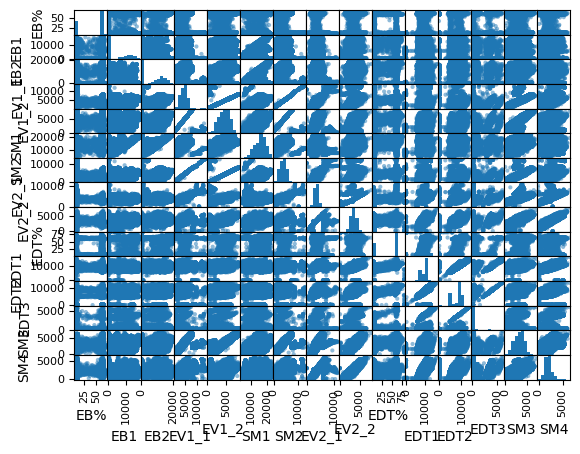

In [17]:
pd.plotting.scatter_matrix(df2)

### Correlación entre variables
Un análisis exploratorio inicial sobre el conjunto de datos mostró que las variaciones de presiones son paulatinas, por lo que es difícil entender qué relaciones hay entre distintos puntos del concretaducto. Aun así, se encontraron situaciones donde ocurrian variaciones abruptas de presión, por lo que se podía buscar más rápidamente cómo se relacionaban los distintos puntos.

Las primeras relaciones significativas se encontraron entre SM2 y EV1_1 dado que, al cambiar una variable, el cambio en la otra se reflejaba de forma casi inmediata.

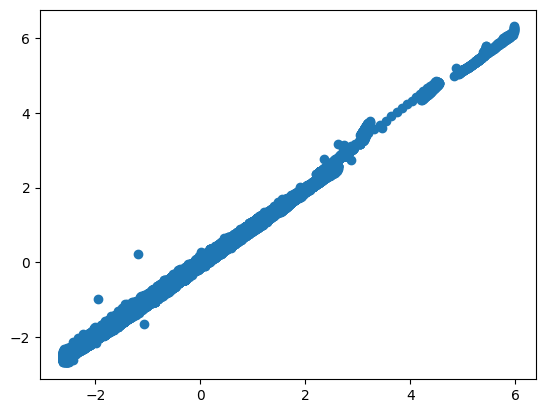

In [18]:
plt.scatter(df_normalized['SM2'], df_normalized['EV1_1'])

Dado que se encontró una relación directa (y lineal) entre estas dos variables, se decidió explorar las relaciones de los otros sensores para verificar si el comportamiento era similar.

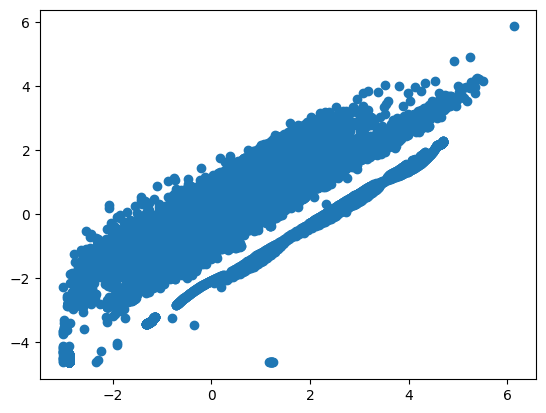

In [19]:
plt.scatter(df_normalized['SM4'], df_normalized['EV2_2'])

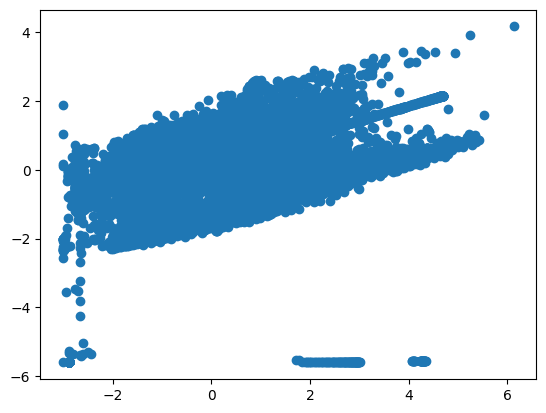

In [20]:
plt.scatter(df_normalized['SM4'], df_normalized['EDT1'])

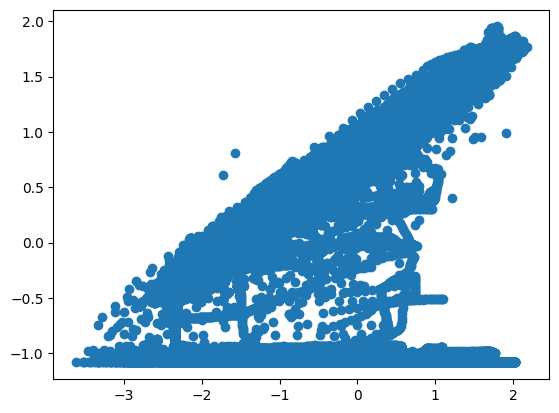

In [21]:
plt.scatter(df_normalized['SM1'], df_normalized['EB2'])

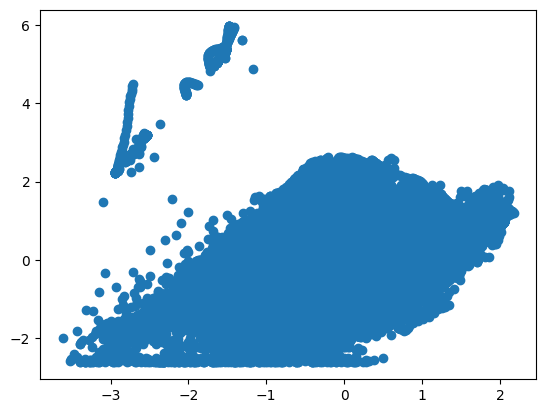

In [22]:
plt.scatter(df_normalized['SM1'], df_normalized['SM2'])

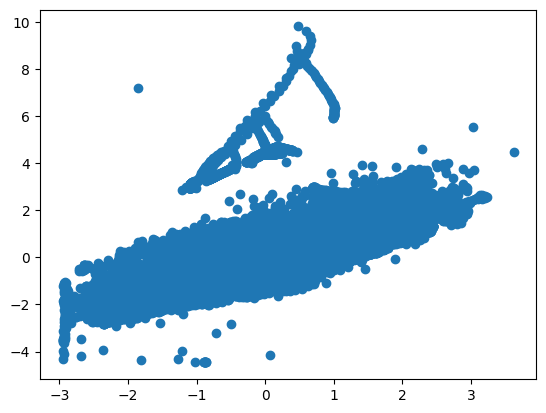

In [23]:
plt.scatter(df_normalized['SM3'], df_normalized['EV2_1'])

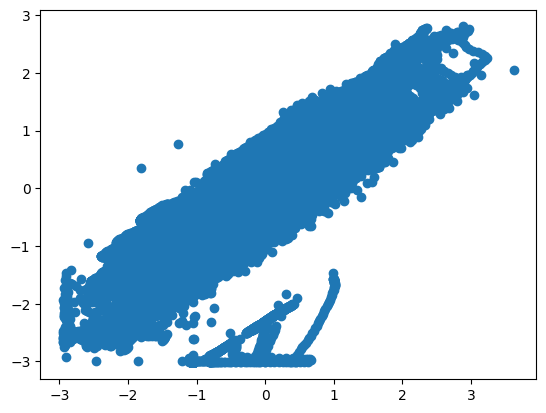

In [24]:
plt.scatter(df_normalized['SM3'], df_normalized['EV1_2'])

# Creación de modelos
A continuación se presentan los modelos creados para cada una de las mediciones de presión.
Para cada estación, se probaron de manera manual una serie de modelos predictivos. En primera instancia, se probraron los modelos lineales:

 -  Regresión Lineal
 -  Regresión Lasso
 -  Elastic Net
 -  Modelo con Descenso por Gradiente Estocástico

En todos los casos, la regresión lineal entregó los mejores resultados, pero no se obtuvo un puntaje satisfactorio.
Por esto, se indagaron modelos no lineales, acción que se justificó al visualizarse cierto comportamiento no lineal entre los datos. Se consideraron los modelos:

 -  Regresión Lineal con Características Polinomiales
 -  Árbol de Decisión Mejorado por Gradiente

Al utilizar estos modelos se mejoraron los resultados, obteniéndose las puntuaciones más altas con el árbol de decisión en todos los sensores, excepto en SM2.
Además se barajaron otros dos modelos, SVM y Random Forest; su entrenamiento tomaba un tiempo considerable, mayor sugerido para la competencia, y en ocasiones los equipos usados no podían completar el trabajo. Por esto, simplemente fueron descartados.
Así, se escogieron los siguientes modelos:

| Estación | Modelo     |
|----------|------------|
| SM1      | XGB        |
| SM2      | Polinomial |
| SM3      | XGB        |
| SM4      | XGB        |

**Nota**: Para simplificar el entendimiento del análisis, se entrega el código de cada modelo, pero dado que no han sido relevantes para la solución final, no poseen mayor explicación.

## Predicción SM1
Se detectó una alta correlación entre SM1 y los sensores de EB. Además, se consideraron los sensores de EV1 y SM2 para mejorar la presición del modelo.

In [25]:
X_1 = df2[['EB%','EB1','EB2','SM2','EV1_1']]
y_1 = df2['SM1']
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, random_state=42, test_size=0.4)

### Regresión Linear

In [26]:
sm1 = LinearRegression()
%time sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
rmse_1 = mean_squared_error(y_test, y_pred, squared=False)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}, RMSE = {rmse_1}')
cross_validate(sm1, X_1, y_1, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

CPU times: total: 0 ns
Wall time: 12 ms
SM1: R2 = 0.7502695851396284, MAE = 1126.1248977259718, RMSE = 1616.59163111323


{'fit_time': array([0.01900125, 0.01403213, 0.01499891, 0.01500559, 0.01200294,
        0.01200175, 0.01198196, 0.01300144, 0.01199841, 0.01200938]),
 'score_time': array([0.00300002, 0.003968  , 0.00299716, 0.0027492 , 0.00199795,
        0.00317693, 0.00299406, 0.003582  , 0.00287652, 0.00199509]),
 'test_r2': array([0.74310418, 0.78935793, 0.31642699, 0.5882594 , 0.61070125,
        0.85453694, 0.88399854, 0.86137599, 0.78405332, 0.46936063]),
 'test_neg_mean_absolute_error': array([-1137.08360968, -1264.67776243, -1645.79705268, -1239.94532856,
        -1049.55559637,  -977.46642678,  -928.02810907, -1109.54507264,
        -1134.75723198, -1122.27354512]),
 'test_neg_root_mean_squared_error': array([-1655.84148474, -1808.02606512, -2657.83923804, -1889.5760648 ,
        -1609.46266902, -1305.81967968, -1108.91236907, -1289.919153  ,
        -1380.29687675, -1500.91500573])}

Observaciones:
Mayor puntuación, dentro de modelos lineales, con un 40% de datos asignados para validación, con todos los datos de presión en [kPa].

### Regresión Linear Polinomial
Se consideró una búsqueda de hiperparámetros, para encontrar el mejor grado del polinomio.

In [27]:
poly = PolynomialFeatures(degree=3)
linear = LinearRegression()
sm1 = make_pipeline(poly, linear)
%time sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
rmse_1 = mean_squared_error(y_test, y_pred, squared=False)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}, RMSE = {rmse_1}')
cross_validate(sm1, X_1, y_1, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

CPU times: total: 172 ms
Wall time: 331 ms
SM1: R2 = 0.9528889045400045, MAE = 510.2336206442199, RMSE = 702.1440311387039


{'fit_time': array([0.46394753, 0.45621443, 0.42436314, 0.42549038, 0.42402053,
        0.45041919, 0.47392154, 0.53213453, 0.46792293, 0.48460245]),
 'score_time': array([0.00900078, 0.00700283, 0.00600195, 0.00600815, 0.00699997,
        0.00700164, 0.00799823, 0.00650716, 0.01100159, 0.00600004]),
 'test_r2': array([0.93993918, 0.96696456, 0.91900646, 0.94894907, 0.91751124,
        0.96471905, 0.95811941, 0.9630267 , 0.94166158, 0.82116565]),
 'test_neg_mean_absolute_error': array([-608.75460051, -493.77940121, -717.17114357, -480.07112953,
        -534.17109583, -457.9649321 , -490.70834863, -511.16460387,
        -528.96898314, -683.16708598]),
 'test_neg_root_mean_squared_error': array([-800.63739547, -716.01510686, -914.87435247, -665.35640621,
        -740.86110454, -643.09774721, -666.3032332 , -666.17349835,
        -717.42512588, -871.32833385])}

### Regresión Lasso

In [28]:
sm1 = LassoCV(max_iter=5000)
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
rmse_1 = mean_squared_error(y_test, y_pred, squared=False)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}, RMSE = {rmse_1}')
cross_validate(sm1, X_1, y_1, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM1: R2 = 0.7351899565507516, MAE = 1180.3034072051905, RMSE = 1664.6841065065062


{'fit_time': array([2.35036182, 2.36339259, 2.16483188, 2.85472107, 2.48517537,
        2.73436975, 2.40966129, 2.16356397, 2.08981895, 2.09382129]),
 'score_time': array([0.00350332, 0.00400043, 0.00300026, 0.00299859, 0.00300002,
        0.00299954, 0.00200057, 0.0030036 , 0.00301027, 0.00299883]),
 'test_r2': array([0.7398648 , 0.75431792, 0.30250899, 0.57864812, 0.62968269,
        0.8376654 , 0.88259891, 0.83178768, 0.74100075, 0.48396749]),
 'test_neg_mean_absolute_error': array([-1139.93805728, -1439.82409648, -1720.98815956, -1272.82904111,
         -982.91069271, -1067.85270015,  -941.62155399, -1233.73734184,
        -1240.04843649, -1104.09737648]),
 'test_neg_root_mean_squared_error': array([-1666.24861035, -1952.62511333, -2684.76058957, -1911.50305792,
        -1569.73523664, -1379.47044815, -1115.58216429, -1420.92827126,
        -1511.64041311, -1480.11307609])}

Observaciones: 
En primer intento, se tuvo menor puntaje y problemas de convergencia.
Se aumenta número de iteraciones y se obtiene mayor demora, manteniendo puntaje.

### Elastic Net

In [29]:
sm1 = ElasticNetCV()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
rmse_1 = mean_squared_error(y_test, y_pred, squared=False)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}, RMSE = {rmse_1}')
cross_validate(sm1, X_1, y_1, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM1: R2 = 0.7091620396776757, MAE = 1248.6822513313455, RMSE = 1744.577037820927


{'fit_time': array([1.08478475, 1.90888596, 0.9837997 , 1.00717831, 1.27005982,
        1.10166264, 1.2495873 , 1.62322474, 1.30258083, 1.020437  ]),
 'score_time': array([0.00299883, 0.00199819, 0.00299621, 0.00199938, 0.00299883,
        0.00499988, 0.00400162, 0.00300074, 0.00300002, 0.00252199]),
 'test_r2': array([0.72964036, 0.71819117, 0.26949034, 0.54955022, 0.60913517,
        0.8103361 , 0.8641063 , 0.80996649, 0.70866063, 0.4650618 ]),
 'test_neg_mean_absolute_error': array([-1167.72679953, -1594.16573293, -1828.00121667, -1330.07288999,
        -1018.55469031, -1162.90460077,  -986.36211732, -1308.81959318,
        -1307.37871872, -1113.09809907]),
 'test_neg_root_mean_squared_error': array([-1698.67843593, -2091.26672819, -2747.57298188, -1976.40398456,
        -1612.6966987 , -1491.07398948, -1200.23188732, -1510.28304727,
        -1603.24107544, -1506.98237022])}

### SGD

In [30]:
sm1 = SGDRegressor()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
rmse_1 = mean_squared_error(y_test, y_pred, squared=False)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}, RMSE = {rmse_1}')
cross_validate(sm1, X_1, y_1, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM1: R2 = -6.689169652440278e+25, MAE = 2.5140389414368012e+16, RMSE = 2.6457616203750056e+16


{'fit_time': array([17.11831141, 12.28007507, 11.12537503,  9.20477414, 11.11605906,
        12.41905379, 11.07892466,  9.20452023, 15.06806087, 10.92488718]),
 'score_time': array([0.00296831, 0.00300097, 0.00262809, 0.00252032, 0.002002  ,
        0.00248909, 0.0024507 , 0.00299764, 0.00300026, 0.00299692]),
 'test_r2': array([-1.08781019e+25, -1.07356285e+24, -5.08277935e+24, -1.56563284e+25,
        -1.79284734e+25, -1.29458738e+25, -2.59952225e+24, -1.72557088e+25,
        -1.12309926e+25, -1.77606280e+25]),
 'test_neg_mean_absolute_error': array([-9.71902553e+15, -3.43256589e+15, -7.02211712e+15, -1.10915535e+16,
        -1.05688144e+16, -1.11916819e+16, -2.76567903e+15, -1.39424158e+16,
        -9.45982296e+15, -8.20244525e+15]),
 'test_neg_root_mean_squared_error': array([-1.07749882e+16, -4.08174498e+15, -7.24747764e+15, -1.16519199e+16,
        -1.09222235e+16, -1.23189172e+16, -5.24943145e+15, -1.43916192e+16,
        -9.95424476e+15, -8.68331435e+15])}

Observaciones: 
Solo funciona con datos estandarizados. Para simplificar la salida del modelo se optó simplemente por usar los datos en sus medidas originales. Esto de forma que no se tenga que pasar por una etapa extra de transformación inversa, y considerando que en la mayoría de los modelos no hubieron mejoras substanciales.

### XGBoost
Se consideró una búsqueda de hiperparámetros, para encontrar los mejores términos de regularización, tasa de aprendizaje, y número de estimadores.

In [31]:
sm1 = XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.3, reg_lambda=0.5, reg_alpha=0.25)
%time sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
rmse_1 = mean_squared_error(y_test, y_pred, squared=False)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}, RMSE = {rmse_1}')
cross_validate(sm1, X_1, y_1, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

CPU times: total: 1.81 s
Wall time: 614 ms
SM1: R2 = 0.9822913331284048, MAE = 269.07354731352467, RMSE = 430.4845219032154


{'fit_time': array([0.65808177, 0.63507009, 1.37362027, 0.74409723, 0.62191033,
        0.66449666, 0.67278266, 0.67898107, 0.73844767, 0.66293883]),
 'score_time': array([0.02400017, 0.01600003, 0.03550959, 0.01600385, 0.11514235,
        0.02551365, 0.02524614, 0.02400041, 0.02300715, 0.02500081]),
 'test_r2': array([0.90262069, 0.96336477, 0.93153319, 0.94883834, 0.87667489,
        0.95273926, 0.95084616, 0.93186034, 0.9334743 , 0.79696949]),
 'test_neg_mean_absolute_error': array([-736.32455666, -542.28899922, -628.86632609, -488.92347794,
        -694.09973964, -564.52774394, -545.79390206, -654.1416246 ,
        -574.8664476 , -742.55830891]),
 'test_neg_root_mean_squared_error': array([-1019.46795958,  -754.01774301,  -841.15554426,  -666.07761633,
         -905.86850052,  -744.31557184,  -721.84543963,  -904.3639574 ,
         -766.11501189,  -928.40403039])}

Observaciones: 
Presenta la mejor puntuación de todos los modelos. Se escoge este.

### Random Forest

Observaciones:
Entrenamiento lento, fuera de plazo máximo. Descartado.

## Predicción SM2
Luego del análisis explorativo, se encontró una alta correlación entre las mediciones de SM2 y EV1, por lo cual se escogen sus sensores como únicas entradas del modelo.

In [32]:
X_2 = df2[['EV1_1', 'EV1_2']]
y_2 = df2['SM2']
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, random_state=42, test_size=0.4)

### Regresión Linear

In [33]:
sm2 = LinearRegression()
%time sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
rmse_2 = mean_squared_error(y_2_test, y_2_pred, squared=False)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}, RMSE = {rmse_2}')
cross_validate(sm2, X_2, y_2, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

CPU times: total: 0 ns
Wall time: 6 ms
SM2: R2 = 0.9951879786633565, MAE = 92.02318713802477, RMSE = 104.11873236322454


{'fit_time': array([0.01199841, 0.00999951, 0.00600004, 0.00700593, 0.00599861,
        0.00900245, 0.00599813, 0.00600195, 0.00900316, 0.00799942]),
 'score_time': array([0.00400043, 0.00400114, 0.00299931, 0.00200009, 0.00351238,
        0.00199866, 0.00200105, 0.00299835, 0.00199771, 0.00299931]),
 'test_r2': array([0.99596396, 0.9932191 , 0.99540395, 0.99555329, 0.99260541,
        0.99452694, 0.99543518, 0.99510928, 0.99411319, 0.99621083]),
 'test_neg_mean_absolute_error': array([ -97.26494303,  -99.63421077, -100.68027935,  -85.22551854,
         -97.86946089,  -90.06072606,  -86.50229174,  -89.37628891,
         -89.3336762 ,  -89.4208195 ]),
 'test_neg_root_mean_squared_error': array([-113.53996299, -114.17631499, -112.89668246,  -96.84096088,
        -108.09356779, -101.68355311,  -96.91684753, -100.02284634,
         -99.19045234, -103.46825414])}

### Regresión Linear Polinomial

In [34]:
poly = PolynomialFeatures(degree=4)
linear = LinearRegression()
sm2 = make_pipeline(poly, linear)
%time sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
rmse_2 = mean_squared_error(y_2_test, y_2_pred, squared=False)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}, RMSE = {rmse_2}')
cross_validate(sm2, X_2, y_2, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

CPU times: total: 31.2 ms
Wall time: 54.5 ms
SM2: R2 = 0.9957065089865466, MAE = 85.67681389206547, RMSE = 98.34909748640945


{'fit_time': array([0.09551811, 0.08013821, 0.08582187, 0.08132362, 0.08750892,
        0.08509302, 0.07951379, 0.08118892, 0.0765152 , 0.07752299]),
 'score_time': array([0.00400138, 0.0049994 , 0.00599504, 0.00500154, 0.00600553,
        0.00400448, 0.00400352, 0.00300097, 0.00400209, 0.00399876]),
 'test_r2': array([0.99613472, 0.9927386 , 0.99502404, 0.99596666, 0.9931142 ,
        0.99520438, 0.9958196 , 0.99555686, 0.99500364, 0.99671422]),
 'test_neg_mean_absolute_error': array([-93.03156759, -98.45496439, -98.1445976 , -79.68042781,
        -92.53570264, -84.30074217, -79.52751088, -84.99380296,
        -81.37981495, -84.8907291 ]),
 'test_neg_root_mean_squared_error': array([-111.1120436 , -118.15233823, -117.47005028,  -92.23000386,
        -104.30853507,  -95.18273941,  -92.74632059,  -95.3362659 ,
         -91.38115047,  -96.35059563])}

### Regresión Lasso

In [35]:
sm2 = LassoCV()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
rmse_2 = mean_squared_error(y_2_test, y_2_pred, squared=False)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}, RMSE = {rmse_2}')
cross_validate(sm2, X_2, y_2, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM2: R2 = 0.9951883007623118, MAE = 91.88570648924468, RMSE = 104.11524764300046


{'fit_time': array([0.49559283, 0.68825078, 0.57708669, 0.46664023, 0.91676855,
        0.45795703, 0.46609426, 0.46366024, 0.46284938, 0.47078061]),
 'score_time': array([0.00300455, 0.00299931, 0.00275731, 0.00199866, 0.00200033,
        0.00199938, 0.00299859, 0.0030055 , 0.00299907, 0.00350857]),
 'test_r2': array([0.99595597, 0.99326853, 0.99539513, 0.99554148, 0.99258782,
        0.99455441, 0.9954458 , 0.99512855, 0.99410707, 0.99616858]),
 'test_neg_mean_absolute_error': array([ -97.18622581,  -99.18962482, -100.64325727,  -85.28426919,
         -97.93573823,  -89.75085964,  -86.21763477,  -88.98861632,
         -89.1458045 ,  -89.75554609]),
 'test_neg_root_mean_squared_error': array([-113.65223747, -113.75933377, -113.00495668,  -96.96949853,
        -108.22206199, -101.42802589,  -96.80410772,  -99.82562433,
         -99.24205305, -104.04345945])}

### Elastic Net

In [36]:
sm2 = ElasticNetCV()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
rmse_2 = mean_squared_error(y_2_test, y_2_pred, squared=False)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}, RMSE = {rmse_2}')
cross_validate(sm2, X_2, y_2, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM2: R2 = 0.9951855931811426, MAE = 92.00102721888321, RMSE = 104.14453675940747


{'fit_time': array([0.52025247, 0.47692418, 0.47677732, 0.45218921, 0.4587481 ,
        0.47068286, 0.62838316, 0.59027791, 0.48596764, 0.52777719]),
 'score_time': array([0.00200081, 0.00300694, 0.00200105, 0.00200224, 0.00299788,
        0.00200081, 0.00300074, 0.00500178, 0.00300026, 0.00199866]),
 'test_r2': array([0.99594561, 0.99328238, 0.99538377, 0.995528  , 0.99259258,
        0.99457024, 0.99545021, 0.99514019, 0.9941008 , 0.99614242]),
 'test_neg_mean_absolute_error': array([ -98.13728602,  -99.07756044, -100.87600594,  -85.61164749,
         -97.92615279,  -89.64476264,  -86.18505785,  -88.92440038,
         -89.15455528,  -90.06703271]),
 'test_neg_root_mean_squared_error': array([-113.79773308, -113.64232276, -113.14430465,  -97.11598511,
        -108.18731862, -101.28053238,  -96.7571502 ,  -99.70627691,
         -99.29480882, -104.39807293])}

### SGD

In [37]:
sm2 = SGDRegressor()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
rmse_2 = mean_squared_error(y_2_test, y_2_pred, squared=False)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}, RMSE = {rmse_2}')
cross_validate(sm2, X_2, y_2, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM2: R2 = -8.183105972667566e+24, MAE = 4047515677196339.0, RMSE = 4293625756269207.5


{'fit_time': array([ 8.212749  , 10.65231085,  6.67104936, 10.05986691,  7.94010282,
         6.5187695 ,  7.43146539,  6.42233324,  5.33053851,  5.01863313]),
 'score_time': array([0.00269198, 0.00280571, 0.00214934, 0.00298715, 0.00601125,
        0.00300002, 0.00300264, 0.00201774, 0.00200558, 0.00216293]),
 'test_r2': array([-3.45742692e+24, -2.32515250e+24, -8.90827972e+24, -2.05258009e+23,
        -1.32012373e+25, -9.74590786e+24, -3.62789567e+23, -6.27192770e+24,
        -3.69776673e+24, -1.46037142e+25]),
 'test_neg_mean_absolute_error': array([-3.11728130e+15, -2.01176356e+15, -4.69716498e+15, -6.02912047e+14,
        -4.37380997e+15, -4.09369685e+15, -8.00694198e+14, -3.44008012e+15,
        -2.39899598e+15, -6.07913442e+15]),
 'test_neg_root_mean_squared_error': array([-3.32313052e+15, -2.11425784e+15, -4.97033659e+15, -6.57945196e+14,
        -4.56720047e+15, -4.29088452e+15, -8.64002537e+14, -3.58190017e+15,
        -2.48599172e+15, -6.42342687e+15])}

### XGBoost

In [38]:
sm2 = XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.3, reg_lambda=0.5, reg_alpha=0.75)
%time sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
rmse_2 = mean_squared_error(y_2_test, y_2_pred, squared=False)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}, RMSE = {rmse_2}')
cross_validate(sm2, X_2, y_2, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

CPU times: total: 938 ms
Wall time: 373 ms
SM2: R2 = 0.995060141752529, MAE = 86.06906057788102, RMSE = 105.49268427862957


{'fit_time': array([0.46956134, 0.38782096, 0.39871502, 0.38708138, 0.39851117,
        0.39134097, 0.39179611, 0.40323234, 0.39580059, 0.4244082 ]),
 'score_time': array([0.01799965, 0.01499915, 0.01499987, 0.01500225, 0.01399636,
        0.01500463, 0.01500225, 0.02200031, 0.02200031, 0.01500058]),
 'test_r2': array([0.98878421, 0.99326714, 0.99307987, 0.99362658, 0.99230023,
        0.99492933, 0.99075293, 0.99223039, 0.99479398, 0.99554188]),
 'test_neg_mean_absolute_error': array([-114.81132227,  -96.46256072,  -98.65914311,  -87.75093119,
         -94.0627896 ,  -86.10472508,  -85.04085143,  -93.59567341,
         -82.19623755,  -88.82570962]),
 'test_neg_root_mean_squared_error': array([-189.27180451, -113.77115622, -138.53064439, -115.93804556,
        -110.30158689,  -97.87422815, -137.93981676, -126.07019781,
         -93.27877437, -112.23049846])}

## Predicción SM3
Luego del análisis explorativo, se encontró una correlación entre las mediciones de SM3 y EV1, y entre SM3 y EV2.
Buscando aumentar el rendimiento del modelo, y analizando de mejor manera las relaciones entre los datos, se consideraron los dos sensores de EV2, el de salida de EV1, y el de SM2, lo cual aumentó en aproximadamente 15% el rendimiento del modelo.

In [39]:
X_3 = df2[['SM2', 'EV1_2', 'EV2_1', 'EV2_2']]
y_3 = df2['SM3']
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, random_state=42, test_size=0.4)

### Regresión Linear

In [40]:
sm3 = LinearRegression()
%time sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test) 
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
rmse_3 = mean_squared_error(y_3_test, y_3_pred, squared=False)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}, RMSE = {rmse_3}')
cross_validate(sm3, X_3, y_3, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

CPU times: total: 78.1 ms
Wall time: 12 ms
SM3: R2 = 0.8663263317109933, MAE = 290.06154586049433, RMSE = 398.7344031146668


{'fit_time': array([0.02199984, 0.01100945, 0.0105114 , 0.01399994, 0.01099396,
        0.0119822 , 0.0119977 , 0.00900054, 0.00900149, 0.00851274]),
 'score_time': array([0.00299978, 0.00300097, 0.00300145, 0.0020051 , 0.0030005 ,
        0.0030005 , 0.00300336, 0.00301218, 0.00199771, 0.00287247]),
 'test_r2': array([0.50788437, 0.89294059, 0.88765675, 0.86834585, 0.81385021,
        0.85793445, 0.85591726, 0.88288475, 0.86277536, 0.86423066]),
 'test_neg_mean_absolute_error': array([-415.42391631, -252.11351064, -287.24628054, -276.72105748,
        -325.84121053, -284.86560823, -282.18071601, -266.32912161,
        -273.8146157 , -334.7465431 ]),
 'test_neg_root_mean_squared_error': array([-712.96252069, -338.76208862, -389.21458326, -388.35141571,
        -435.72363101, -392.47981101, -393.95493117, -366.96996245,
        -389.71543016, -463.78868518])}

### Regresión Linear Polinomial

In [41]:
poly = PolynomialFeatures(degree=4)
linear = LinearRegression()
%time sm3 = make_pipeline(poly, linear)
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
rmse_3 = mean_squared_error(y_3_test, y_3_pred, squared=False)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}, RMSE = {rmse_3}')
cross_validate(sm3, X_3, y_3, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

CPU times: total: 0 ns
Wall time: 0 ns
SM3: R2 = 0.9134248735712982, MAE = 212.9049616762026, RMSE = 320.8908566765248


{'fit_time': array([0.60143352, 0.59391809, 0.66719699, 0.65669966, 0.6584487 ,
        0.61168098, 0.59340143, 0.59432817, 0.59219837, 0.59803295]),
 'score_time': array([0.01000381, 0.00700164, 0.00800252, 0.00800204, 0.00851655,
        0.00756049, 0.00851011, 0.00751233, 0.00851727, 0.00700545]),
 'test_r2': array([-5.08988339,  0.89473539,  0.92402772,  0.91785416,  0.87292423,
         0.91198352,  0.53571174,  0.93007502,  0.91511488,  0.89604461]),
 'test_neg_mean_absolute_error': array([-719.57889944, -199.35449156, -215.65893533, -212.35078971,
        -259.14010478, -198.10363507, -216.45513753, -181.23172183,
        -193.41188659, -254.80557912]),
 'test_neg_root_mean_squared_error': array([-2508.05820237,  -335.91048486,  -320.06869344,  -306.76118814,
         -360.00721882,  -308.92633872,  -707.18722936,  -283.55672352,
         -306.51190809,  -405.82873886])}

### Regresión Lasso

In [42]:
sm3 = LassoCV()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
rmse_3 = mean_squared_error(y_3_test, y_3_pred, squared=False)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}, RMSE = {rmse_3}')
cross_validate(sm3, X_3, y_3, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM3: R2 = 0.8663192489145828, MAE = 290.0359064972062, RMSE = 398.74496659072855


{'fit_time': array([0.80398488, 0.5691967 , 0.5659883 , 0.56409907, 0.56595755,
        0.55886602, 0.58018303, 0.55680108, 0.57275343, 0.56277251]),
 'score_time': array([0.00199914, 0.00300074, 0.00200057, 0.00251031, 0.00352097,
        0.00299883, 0.00199962, 0.00299835, 0.0015111 , 0.00200129]),
 'test_r2': array([0.64404072, 0.89098537, 0.88543231, 0.86723995, 0.81224237,
        0.85898758, 0.85698323, 0.88151117, 0.86190875, 0.86351563]),
 'test_neg_mean_absolute_error': array([-386.13345194, -250.87525855, -285.94380645, -279.5614066 ,
        -332.184771  , -282.66959431, -281.52495865, -262.62645633,
        -275.44672398, -334.24909108]),
 'test_neg_root_mean_squared_error': array([-606.36382463, -341.84149171, -393.049007  , -389.97908808,
        -437.60132539, -391.0223892 , -392.49492749, -369.11567114,
        -390.94407112, -465.00834507])}

### Elastic Net

In [43]:
sm3 = ElasticNetCV()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
rmse_3 = mean_squared_error(y_3_test, y_3_pred, squared=False)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}, RMSE = {rmse_3}')
cross_validate(sm3, X_3, y_3, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM3: R2 = 0.8663014514728018, MAE = 290.00771589320857, RMSE = 398.7715089466235


{'fit_time': array([0.70238256, 0.55289054, 0.51189327, 0.50900412, 0.75729871,
        0.57522035, 0.99878693, 0.51613474, 0.50363421, 0.50024796]),
 'score_time': array([0.00199962, 0.00299788, 0.00200009, 0.00351715, 0.00399804,
        0.00199938, 0.00200033, 0.00199795, 0.00200129, 0.00199938]),
 'test_r2': array([0.69197983, 0.89043555, 0.88375374, 0.86703019, 0.81193397,
        0.85968164, 0.85822802, 0.88075061, 0.8616157 , 0.86349509]),
 'test_neg_mean_absolute_error': array([-373.94507102, -249.27105413, -285.52390936, -280.03632088,
        -333.42803309, -280.72935989, -280.37296154, -260.80711567,
        -275.24597743, -333.46609057]),
 'test_neg_root_mean_squared_error': array([-564.05661785, -342.70244469, -395.9178705 , -390.28704674,
        -437.9605677 , -390.05889799, -390.78309612, -370.29842883,
        -391.35867305, -465.0433279 ])}

### SGD

In [44]:
sm3 = SGDRegressor()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
rmse_3 = mean_squared_error(y_3_test, y_3_pred, squared=False)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}, RMSE = {rmse_3}')
cross_validate(sm3, X_3, y_3, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM3: R2 = -4.2646263340915085e+24, MAE = 2053365912573265.0, RMSE = 2252170510658768.0


{'fit_time': array([ 6.64995742,  7.61079526, 12.28980231,  8.14028883,  9.65367079,
        11.12577009, 11.73787165,  8.70832086,  8.32442927,  7.00316238]),
 'score_time': array([0.00246882, 0.00300074, 0.00221896, 0.00299931, 0.00299978,
        0.0040071 , 0.00199914, 0.00299907, 0.00299788, 0.00211239]),
 'test_r2': array([-1.47409892e+25, -7.57946223e+24, -7.88719759e+24, -1.95032040e+23,
        -1.91475325e+24, -5.36179158e+25, -1.29328343e+25, -1.30602039e+25,
        -1.62844057e+25, -1.64145136e+25]),
 'test_neg_mean_absolute_error': array([-3.60413216e+15, -2.66478676e+15, -3.18046682e+15, -3.39410382e+14,
        -1.32922886e+15, -7.40453718e+15, -3.59691483e+15, -3.75095547e+15,
        -4.14037063e+15, -4.87897034e+15]),
 'test_neg_root_mean_squared_error': array([-3.90208240e+15, -2.85037220e+15, -3.26119659e+15, -4.72672787e+14,
        -1.39744989e+15, -7.62479026e+15, -3.73239343e+15, -3.87524143e+15,
        -4.24538923e+15, -5.09956694e+15])}

### XGBoost

In [45]:
sm3 = XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.3, reg_lambda=0.5, reg_alpha=0.5)
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
rmse_3 = mean_squared_error(y_3_test, y_3_pred, squared=False)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}, RMSE = {rmse_3}')
cross_validate(sm3, X_3, y_3, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM3: R2 = 0.9519092623430819, MAE = 141.97326758475268, RMSE = 239.16162456358163


{'fit_time': array([0.55584502, 0.56836057, 0.57577062, 0.56056595, 0.60454798,
        0.59836936, 0.58398676, 0.57400036, 0.58306766, 1.21116924]),
 'score_time': array([0.02299857, 0.0180006 , 0.02399945, 0.01499844, 0.01899981,
        0.02500463, 0.02351952, 0.02452302, 0.01552081, 0.03000069]),
 'test_r2': array([0.85677389, 0.91699336, 0.93047941, 0.93859029, 0.90172565,
        0.93601267, 0.92496546, 0.94611306, 0.93179162, 0.93980283]),
 'test_neg_mean_absolute_error': array([-266.0885251 , -180.23058878, -194.60040924, -170.60864942,
        -197.71290647, -150.85615886, -163.70991437, -141.33179439,
        -157.66666191, -187.33150002]),
 'test_neg_root_mean_squared_error': array([-384.6309451 , -298.29006919, -306.17685108, -265.23213635,
        -316.59199273, -263.40251894, -284.29628097, -248.92329616,
        -274.75805205, -308.82135401])}

Observaciones:
El modelo obtenía un puntaje de R2 de 89% aproximadamente. Se hizo un ajuste manual de hiperparámetros, lo que elevó la puntuación a ~95%. Para corroborar dichos valores, se hizo una búsqueda de hiperparámetros con validación cruzada, 
Al hacer este análisis, se encontró que los hiperparámetros obtenidos de manera manual seguían siendo los mejores, por lo que se mantuvieron estos para la solución final..

## Predicción SM4
Luego del análisis explorativo, se encontró una correlación entre las mediciones de SM4 y EV2, y entre SM4 y EDT1.

In [46]:
X_4 = df2[['EV2_1','EV2_2', 'EDT%', 'EDT1']] 
y_4 = df2['SM4']
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, random_state=42, test_size=0.4)

### Regresión Linear

In [47]:
sm4 = LinearRegression()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
rmse_4 = mean_squared_error(y_4_test, y_4_pred, squared=False)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}, RMSE = {rmse_4}')
cross_validate(sm4, X_4, y_4, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM4: R2 = 0.8760905570138721, MAE = 158.73424488737462, RMSE = 254.6103206588534


{'fit_time': array([0.01799726, 0.01099873, 0.01600623, 0.01401043, 0.01400971,
        0.01100206, 0.0129981 , 0.01399779, 0.01100111, 0.0100174 ]),
 'score_time': array([0.00300097, 0.00299931, 0.00299764, 0.00351191, 0.0029881 ,
        0.00300336, 0.00400329, 0.00299525, 0.00200057, 0.00299811]),
 'test_r2': array([0.85193175, 0.78031824, 0.84687481, 0.88553092, 0.89474944,
        0.89956036, 0.84338332, 0.88415195, 0.91305194, 0.79014787]),
 'test_neg_mean_absolute_error': array([-219.47742478, -175.54110903, -179.55394515, -130.7369498 ,
        -165.7542249 , -129.57263135, -135.18395839, -139.03156909,
        -142.45649981, -199.32190095]),
 'test_neg_root_mean_squared_error': array([-344.45362333, -266.8002214 , -264.48459626, -215.14224349,
        -260.77163033, -215.89980975, -247.04363615, -234.69178747,
        -235.25369459, -300.53675782])}

### Regresión Lineal Polinomial

In [48]:
poly = PolynomialFeatures(degree=4)
linear = LinearRegression()
sm4 = make_pipeline(poly, linear)
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
rmse_4 = mean_squared_error(y_4_test, y_4_pred, squared=False)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}, RMSE = {rmse_4}')
cross_validate(sm4, X_4, y_4, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM4: R2 = 0.9277962653478198, MAE = 87.08924855419416, RMSE = 194.35854189570045


{'fit_time': array([0.63788581, 0.65372705, 0.63460803, 0.64745641, 0.67312741,
        0.62847185, 1.44775391, 0.69715953, 0.62894034, 0.82128024]),
 'score_time': array([0.01200771, 0.00900197, 0.01350331, 0.0080018 , 0.00999808,
        0.00800061, 0.01200151, 0.00899982, 0.00900292, 0.01100492]),
 'test_r2': array([-19.74946825,   0.84201379,  -1.92602584,   0.94484809,
          0.94667113,   0.95411713,   0.92431427,   0.17948915,
          0.94709923,   0.83614466]),
 'test_neg_mean_absolute_error': array([-796.85614906, -123.89283442, -196.54368236,  -73.94350318,
         -84.39877934,  -59.16099808,  -69.87912917, -131.82540913,
         -86.57589874, -109.25571544]),
 'test_neg_root_mean_squared_error': array([-4077.58730179,  -226.25531229, -1156.15522895,  -149.33509682,
         -185.62194755,  -145.92340432,  -171.7361259 ,  -624.59097267,
         -183.50059846,  -265.5652248 ])}

### Regresión Lasso

In [49]:
sm4 = LassoCV()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
rmse_4 = mean_squared_error(y_4_test, y_4_pred, squared=False)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}, RMSE = {rmse_4}')
cross_validate(sm4, X_4, y_4, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM4: R2 = 0.8743440421327682, MAE = 166.47632528620463, RMSE = 256.3984196781463


{'fit_time': array([0.56130457, 1.11237121, 0.99050069, 0.49370408, 0.49491882,
        0.4935689 , 0.49536061, 0.49089241, 0.47730875, 0.49815488]),
 'score_time': array([0.00299931, 0.00199986, 0.00199842, 0.00299835, 0.00199914,
        0.00200105, 0.00199771, 0.00199986, 0.00299978, 0.00200105]),
 'test_r2': array([0.86836892, 0.77722442, 0.84380328, 0.88673681, 0.89310201,
        0.89728986, 0.84018071, 0.87690531, 0.9111036 , 0.78659668]),
 'test_neg_mean_absolute_error': array([-223.2399405 , -181.35550679, -185.73464183, -135.75041834,
        -176.75006669, -139.22168046, -143.19194287, -147.21789955,
        -152.01260727, -209.95063742]),
 'test_neg_root_mean_squared_error': array([-324.7723194 , -268.67235734, -267.12407171, -214.00602443,
        -262.8045726 , -218.32645054, -249.55671475, -241.92079514,
        -237.87487622, -303.06898374])}

### Elastic Net

In [50]:
sm4 = ElasticNetCV()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
rmse_4 = mean_squared_error(y_4_test, y_4_pred, squared=False)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}, RMSE = {rmse_4}')
cross_validate(sm4, X_4, y_4, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM4: R2 = 0.8337612634590793, MAE = 212.13140705593008, RMSE = 294.910283236396


{'fit_time': array([0.5385437 , 0.47713089, 0.47245288, 0.47244072, 0.49015617,
        0.48100615, 0.48338389, 0.60834765, 1.15778255, 0.4990418 ]),
 'score_time': array([0.00300074, 0.00200152, 0.00199986, 0.00300026, 0.00199747,
        0.00200009, 0.00199962, 0.00200033, 0.00199986, 0.00300074]),
 'test_r2': array([0.76576272, 0.74629231, 0.80524153, 0.86689454, 0.86441925,
        0.86742247, 0.79788821, 0.80558741, 0.88390996, 0.73551325]),
 'test_neg_mean_absolute_error': array([-302.13184622, -212.07322229, -218.89495648, -171.0958617 ,
        -230.2143411 , -186.07047951, -186.76970483, -197.59769594,
        -204.32980535, -264.72365974]),
 'test_neg_root_mean_squared_error': array([-433.23924803, -286.71868853, -298.28076116, -231.99549088,
        -295.96963169, -248.04738719, -280.64059463, -304.02950557,
        -271.83412356, -337.39828014])}

### SGD

In [51]:
sm4 = SGDRegressor()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
rmse_4 = mean_squared_error(y_4_test, y_4_pred, squared=False)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}, RMSE = {rmse_4}')
cross_validate(sm4, X_4, y_4, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM4: R2 = -3.8082686188974082e+25, MAE = 4394419971043472.5, RMSE = 4463623840786166.5


{'fit_time': array([11.3307662 ,  7.67030668,  5.60708833, 10.48369598,  7.7880466 ,
         9.08181357,  8.27351999,  7.25587296, 10.03738236, 10.75768495]),
 'score_time': array([0.00199986, 0.00299883, 0.00201893, 0.00200081, 0.00261164,
        0.00200081, 0.00199986, 0.00302434, 0.00299644, 0.00199938]),
 'test_r2': array([-4.02766758e+24, -2.94679874e+26, -4.52713048e+26, -1.63970977e+26,
        -3.63641964e+25, -2.44922256e+26, -3.11036358e+24, -6.47059117e+24,
        -1.32455297e+26, -6.00446428e+25]),
 'test_neg_mean_absolute_error': array([-1.73088215e+15, -9.59473366e+15, -1.41482733e+16, -8.02183227e+15,
        -4.78032388e+15, -1.05049092e+16, -9.62196804e+14, -1.72643336e+15,
        -9.08000789e+15, -4.97665056e+15]),
 'test_neg_root_mean_squared_error': array([-1.79649740e+15, -9.77157182e+15, -1.43809831e+16, -8.14263736e+15,
        -4.84713527e+15, -1.06613896e+16, -1.10093136e+15, -1.75398356e+15,
        -9.18208192e+15, -5.08367805e+15])}

### XGBoost

In [52]:
sm4 = XGBRegressor(random_state=42, n_estimators=175, learning_rate=0.302, reg_lambda=1, reg_alpha=0.5)
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
rmse_4 = mean_squared_error(y_4_test, y_4_pred, squared=False)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}, RMSE = {rmse_4}')
cross_validate(sm4, X_4, y_4, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))

SM4: R2 = 0.9657182823470207, MAE = 57.788102225919836, RMSE = 133.92297502354248


{'fit_time': array([0.54567981, 0.53163075, 0.52935076, 0.54975915, 0.46481824,
        0.44595575, 0.49460292, 1.00136876, 0.53108239, 0.53125525]),
 'score_time': array([0.01851106, 0.01699138, 0.01400423, 0.02199912, 0.02400136,
        0.01500154, 0.0150001 , 0.01500154, 0.01400328, 0.02099967]),
 'test_r2': array([0.90215827, 0.88663679, 0.94185833, 0.95884412, 0.96508828,
        0.96615654, 0.9333452 , 0.93271302, 0.96786487, 0.94385696]),
 'test_neg_mean_absolute_error': array([-180.08908914, -109.9064289 ,  -98.88011661,  -63.78573414,
         -60.82049644,  -57.44105579,  -60.85016627,  -79.98127249,
         -66.55581613,  -76.23515855]),
 'test_neg_root_mean_squared_error': array([-280.00245588, -191.65725528, -162.97493305, -129.00233071,
        -150.18750051, -125.32480699, -161.16487075, -178.86239711,
        -143.01992073, -155.44933203])}